We get K = 5.210914242833184, with error = 0.1291603479857514
We get r = 0.0034596189860200666, with error = 0.00011244736043861353


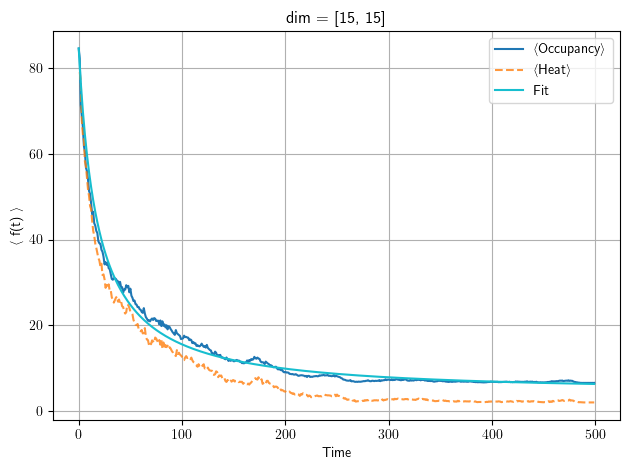

Plot Saved!
Dimension: [15, 15]
We get K = 15.103769398979736, with error = 0.3053959242639392
We get r = 0.00538452503523449, with error = 0.00017242788902094953


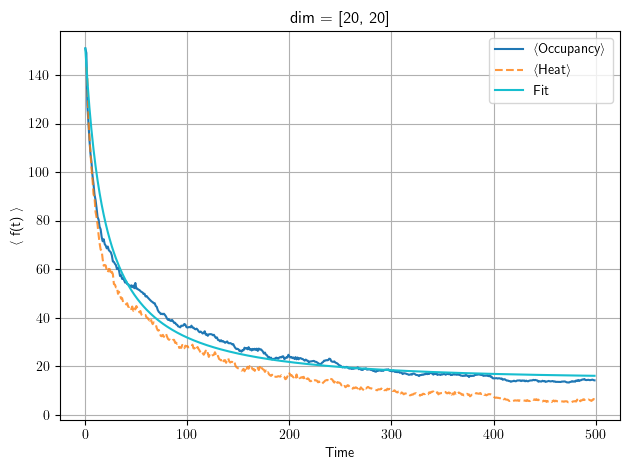

Plot Saved!
Dimension: [20, 20]
We get K = 35.62786763463986, with error = 0.3748119098357878
We get r = 0.009513403166363862, with error = 0.0002174119374050389


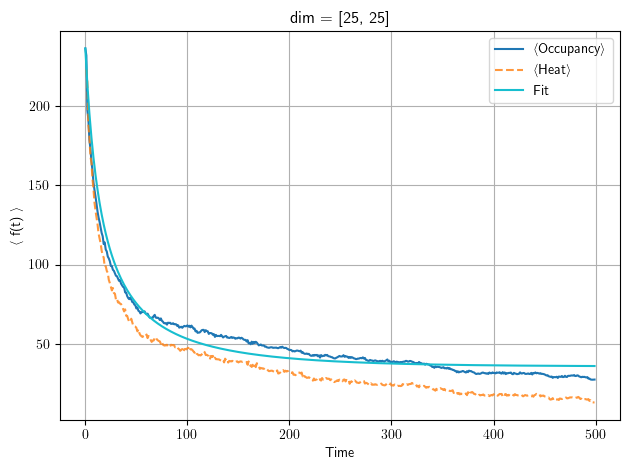

Plot Saved!
Dimension: [25, 25]
We get K = 55.70489294975057, with error = 0.6494644453968781
We get r = 0.009424926623403046, with error = 0.0002470161714308458


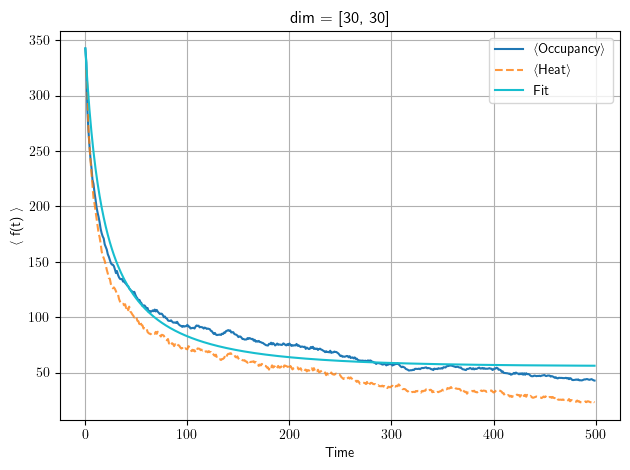

Plot Saved!
Dimension: [30, 30]
We get K = 80.38868848555451, with error = 0.4656482611071646
We get r = 0.012038162726528731, with error = 0.0001769314569924913


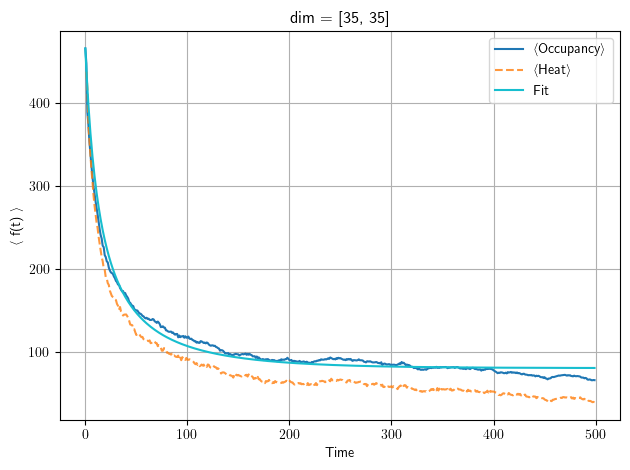

Plot Saved!
Dimension: [35, 35]
We get K = 106.17269053037805, with error = 0.5337674013035124
We get r = 0.012532123595846547, with error = 0.0001634306154334431


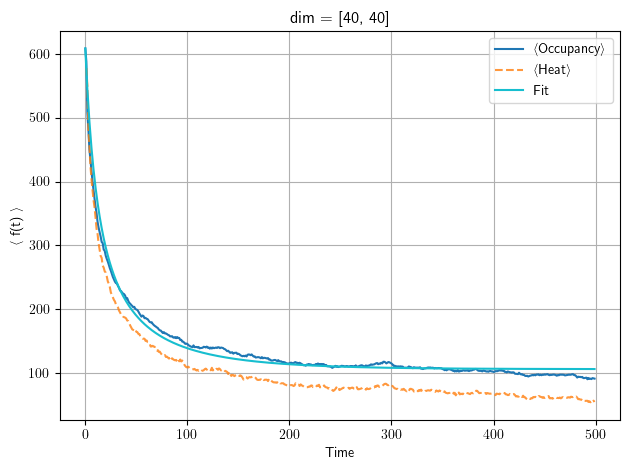

Plot Saved!
Dimension: [40, 40]


,block,bee_hive,loaf,boat,ship,tub,pond,blinker,toad,beacon,glider
dimension,,,,,,,,,,,
"[15, 15]",20194,8719,4739,4247,499,884,3,16875,10,193,397
"[20, 20]",36513,11127,7355,6850,949,941,784,35424,14,15,540
"[25, 25]",52110,27126,8481,8685,1441,2151,2348,56356,68,164,518
"[30, 30]",78895,32908,10072,12135,2526,3563,3197,75788,122,402,914
"[35, 35]",97379,47778,16256,13856,1486,3432,3887,101697,199,88,1183
"[40, 40]",133577,59570,19676,21840,2426,5097,4019,121994,217,136,1708


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ast
from scipy.optimize import curve_fit

# Logistic regression of populations
def f2(x, K, r):
    x0 = df_res['occupancy'].iloc[0]
    return (K*x0*np.exp(r*x))/(K+x0*(np.exp(x*r)-1))

f2v = np.vectorize(f2)

def consecutive(data, stepsize=1):    
    return np.split(data, np.where(np.diff(data) != stepsize)[0]+1)

pattern_period = {"block" : 1, "bee_hive" : 1, "loaf" : 1, "boat" : 1, "ship" : 1, "tub" : 1, "pond" : 1, "blinker" : 1, "toad" : 2, "beacon" : 2, "glider":4}


folder_name = 'data/'
all_dim = [[i, i] for i in [15, 20, 25, 30, 35, 40]]
all_seed = list(range(100, 200)) 
native = 37.5 
all_native = [native]
graph = True
iterations = 500
list_iterations = list(range(iterations))      # This is useful when decomposing the dataframe

patterns = ['block', 'bee_hive', 'loaf', 'boat', 'ship', 'tub', 'pond', 'blinker', 'toad', 'beacon', 'glider']
others = ['heat', 'occupancy']
columns = patterns + others

# Analysis of occupancies and heats

# tuples = [(str(dim), str(native)) for dim in all_dim]
# index = pd.MultiIndex.from_tuples(tuples, names=['dimension', 'natives'])
index = [(str(dim)) for dim in all_dim]
all_freq, all_lives = [], []
K, r, K_err, r_err = [], [], [], []
for dim in all_dim:
    df = pd.DataFrame(columns=columns)
    for seed in all_seed:
        file_name = folder_name+str(dim[0])+"_"+str(dim[1])+"/"+str(seed)+'.csv'
        df_tmp = pd.read_csv(file_name, sep=';', skiprows=[0], names=columns, header=None)
        for col in df_tmp.columns:
            df_tmp[col] = df_tmp[col].apply(lambda x: ast.literal_eval(str(x)))
        df = pd.concat([df, df_tmp], ignore_index=True)
    
    # Analysis of occupancies and heats
    n = len(all_seed)
    df_per_native = df[others]
    df_res = pd.DataFrame([((lambda z: df_per_native.loc[z:df.shape[0]:iterations])(z)).mean() for z in list_iterations])     # In this way we average on same time for different seeds
    if graph:
        popt, pcov = curve_fit(f2, list_iterations, df_res['occupancy'])
        print(f"We get K = {popt[0]}, with error = {np.sqrt(pcov[0][0])}")
        K.append(popt[0])
        K_err.append(np.sqrt(pcov[0][0]))
        print(f"We get r = {popt[1]}, with error = {np.sqrt(pcov[1][1])}")
        r.append(popt[1])
        r_err.append(np.sqrt(pcov[1][1]))
        plt.rcParams['text.usetex'] = True
        plt.title(f"dim = {dim}")
        plt.plot(df_res['occupancy'], label=r'$\langle$Occupancy$\rangle$', color='tab:blue')
        plt.plot(list_iterations[1:], df_res['heat'].iloc[1:], label=r'$\langle$Heat$\rangle$', ls='--', alpha=0.8, color='tab:orange')
        plt.plot(f2v(list_iterations, popt[0], popt[1]), label='Fit', color='tab:cyan')
        plt.xlabel('Time')
        plt.ylabel(r'$\langle$ f(t) $\rangle$')
        plt.legend(loc='best')
        plt.grid()
        plt.tight_layout()
        plt.savefig('plots/'+str(dim[0])+"_"+str(dim[1])+'.png', bbox_inches='tight', dpi=300)
        plt.show()
        print("Plot Saved!")
    
    # Analysis of frequencies and average lives
    frequencies, lives = [], []
    for col in patterns:
        keep_track = []
        df_frequencies = df[col]
        df_frequencies = df_frequencies[df_frequencies != 0].dropna()
        freq = 0
        for i in range(df_frequencies.shape[0]):
            element = df_frequencies.iloc[i]
            
            for sub_element in element:
                freq += 1
                chir, rot, x, y = sub_element
                keep_track.append([x, y, chir, rot, df_frequencies.index[i]])      
        df_keep_track = pd.DataFrame(keep_track, columns=['x', 'y', 'chir', 'rot', 'time'])
        
        unique_lists_in_items = df_keep_track.groupby(['x', 'y', 'chir'])['time'].apply(consecutive, stepsize=pattern_period[col])  # .to_numpy()
        freq_live = 0
        life = []
        for k in range(len(unique_lists_in_items)):
            tmp = unique_lists_in_items.iloc[k]
            freq_live += len(tmp)
            for j in range(len(tmp)):
                life.append(len(tmp[j]))
                    
        frequencies.append(freq)
        lives.append(sum(life)/freq_live)

    all_freq.append(frequencies)
    all_lives.append(lives)
    print(f"Dimension: {dim}")

df_final = pd.DataFrame(all_freq, index=index, columns=patterns)
df_final.index.name = 'dimension'
df_final

In [2]:
df_lives = pd.DataFrame(all_lives, index=index, columns=patterns)
df_lives.index.name = 'dimension'
df_lives

,block,bee_hive,loaf,boat,ship,tub,pond,blinker,toad,beacon,glider
dimension,,,,,,,,,,,
"[15, 15]",33.050736,89.886598,131.638889,64.348485,35.642857,44.200000,1.500000,15.093918,1.000000,193.000000,1.0
"[20, 20]",22.102300,44.508000,57.460938,47.902098,30.612903,22.404762,26.133333,11.210127,1.166667,1.875000,1.0
"[25, 25]",16.739480,49.955801,36.399142,29.046823,24.016667,16.937008,46.039216,9.197976,2.720000,13.666667,1.0
"[30, 30]",15.567285,36.162637,25.759591,26.323210,28.704545,18.178571,38.059524,7.401895,2.301887,23.647059,1.0
"[35, 35]",14.441495,37.739336,28.822695,23.016611,11.257576,12.853933,32.663866,7.223824,2.618421,5.500000,1.0
"[40, 40]",14.350774,33.693439,27.214385,26.187050,12.904255,14.119114,30.446970,6.438358,2.855263,4.857143,1.0


In [3]:
rows = [df_final.iloc[i].sum() for i in range(len(all_dim))]
df_final2 = df_final/np.array(rows).reshape(len(rows), -1)
df_final2

,block,bee_hive,loaf,boat,ship,tub,pond,blinker,toad,beacon,glider
dimension,,,,,,,,,,,
"[15, 15]",0.355779,0.153612,0.083492,0.074824,0.008791,0.015574,0.000053,0.297304,0.000176,0.003400,0.006994
"[20, 20]",0.363270,0.110703,0.073175,0.068151,0.009442,0.009362,0.007800,0.352436,0.000139,0.000149,0.005372
"[25, 25]",0.326815,0.170124,0.053190,0.054469,0.009037,0.013490,0.014726,0.353444,0.000426,0.001029,0.003249
"[30, 30]",0.357765,0.149228,0.045673,0.055029,0.011455,0.016157,0.014497,0.343675,0.000553,0.001823,0.004145
"[35, 35]",0.339015,0.166334,0.056594,0.048238,0.005173,0.011948,0.013532,0.354048,0.000693,0.000306,0.004118
"[40, 40]",0.360765,0.160887,0.053141,0.058986,0.006552,0.013766,0.010855,0.329482,0.000586,0.000367,0.004613


In [4]:
print(df_final2.to_markdown())

| dimension   |    block |   bee_hive |      loaf |      boat |       ship |        tub |        pond |   blinker |        toad |      beacon |     glider |
|:------------|---------:|-----------:|----------:|----------:|-----------:|-----------:|------------:|----------:|------------:|------------:|-----------:|
| [15, 15]    | 0.355779 |   0.153612 | 0.0834919 | 0.0748238 | 0.0087914  | 0.0155743  | 5.28541e-05 |  0.297304 | 0.00017618  | 0.00340028  | 0.00699436 |
| [20, 20]    | 0.36327  |   0.110703 | 0.0731753 | 0.0681511 | 0.00944166 | 0.00936207 | 0.00780006  |  0.352436 | 0.000139287 | 0.000149236 | 0.00537249 |
| [25, 25]    | 0.326815 |   0.170124 | 0.0531898 | 0.0544692 | 0.00903743 | 0.0134903  | 0.0147258   |  0.353444 | 0.000426471 | 0.00102855  | 0.00324871 |
| [30, 30]    | 0.357765 |   0.149228 | 0.0456734 | 0.0550285 | 0.0114546  | 0.0161571  | 0.0144974   |  0.343675 | 0.000553233 | 0.00182295  | 0.00414471 |
| [35, 35]    | 0.339015 |   0.166334 | 0.0565936 | 0.0482

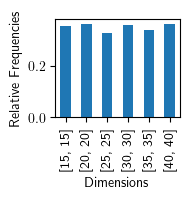

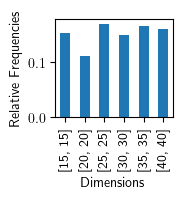

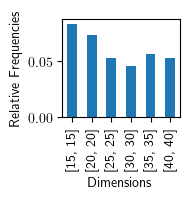

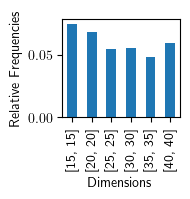

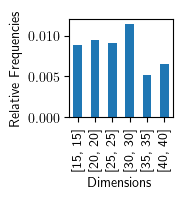

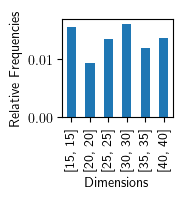

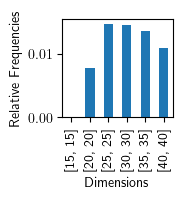

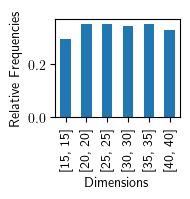

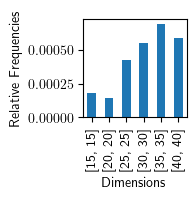

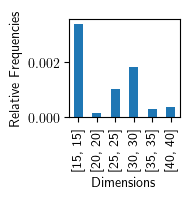

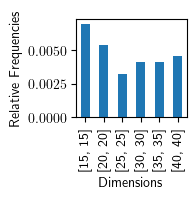

In [5]:
for col in patterns:
    ax = df_final2[col].plot(kind='bar', figsize=(2, 2), xlabel='Dimensions', ylabel='Relative Frequencies')#, layout=(2, 2))
    plt.tight_layout()
    plt.xticks(rotation=90)
    plt.savefig('plots/'+col+"_"+col+'.png', bbox_inches='tight', dpi=300)
    plt.show()

In [6]:
to = np.array([df_final2['block'].values, df_final2['blinker'].values, df_final2['bee_hive'].values, df_final2['loaf'].values, df_final2['boat'].values, df_final2['pond'].values, df_final2['tub'].values, df_final2['ship'].values, df_final2['toad'].values, df_final2['beacon'].values])

In [7]:
df_print = pd.DataFrame(data=to.T, columns=['block', 'blinker', 'bee_hive', 'loaf', 'boat', 'pond','tub', 'ship', 'toad', 'beacon'])

In [8]:
df_print

,block,blinker,bee_hive,loaf,boat,pond,tub,ship,toad,beacon
0,0.355779,0.297304,0.153612,0.083492,0.074824,0.000053,0.015574,0.008791,0.000176,0.003400
1,0.363270,0.352436,0.110703,0.073175,0.068151,0.007800,0.009362,0.009442,0.000139,0.000149
2,0.326815,0.353444,0.170124,0.053190,0.054469,0.014726,0.013490,0.009037,0.000426,0.001029
3,0.357765,0.343675,0.149228,0.045673,0.055029,0.014497,0.016157,0.011455,0.000553,0.001823
4,0.339015,0.354048,0.166334,0.056594,0.048238,0.013532,0.011948,0.005173,0.000693,0.000306
5,0.360765,0.329482,0.160887,0.053141,0.058986,0.010855,0.013766,0.006552,0.000586,0.000367


In [9]:
from matplotlib import cm

In [10]:
subpat = ['block', 'blinker', 'bee_hive', 'loaf', 'boat', 'pond','tub', 'ship', 'toad', 'beacon']

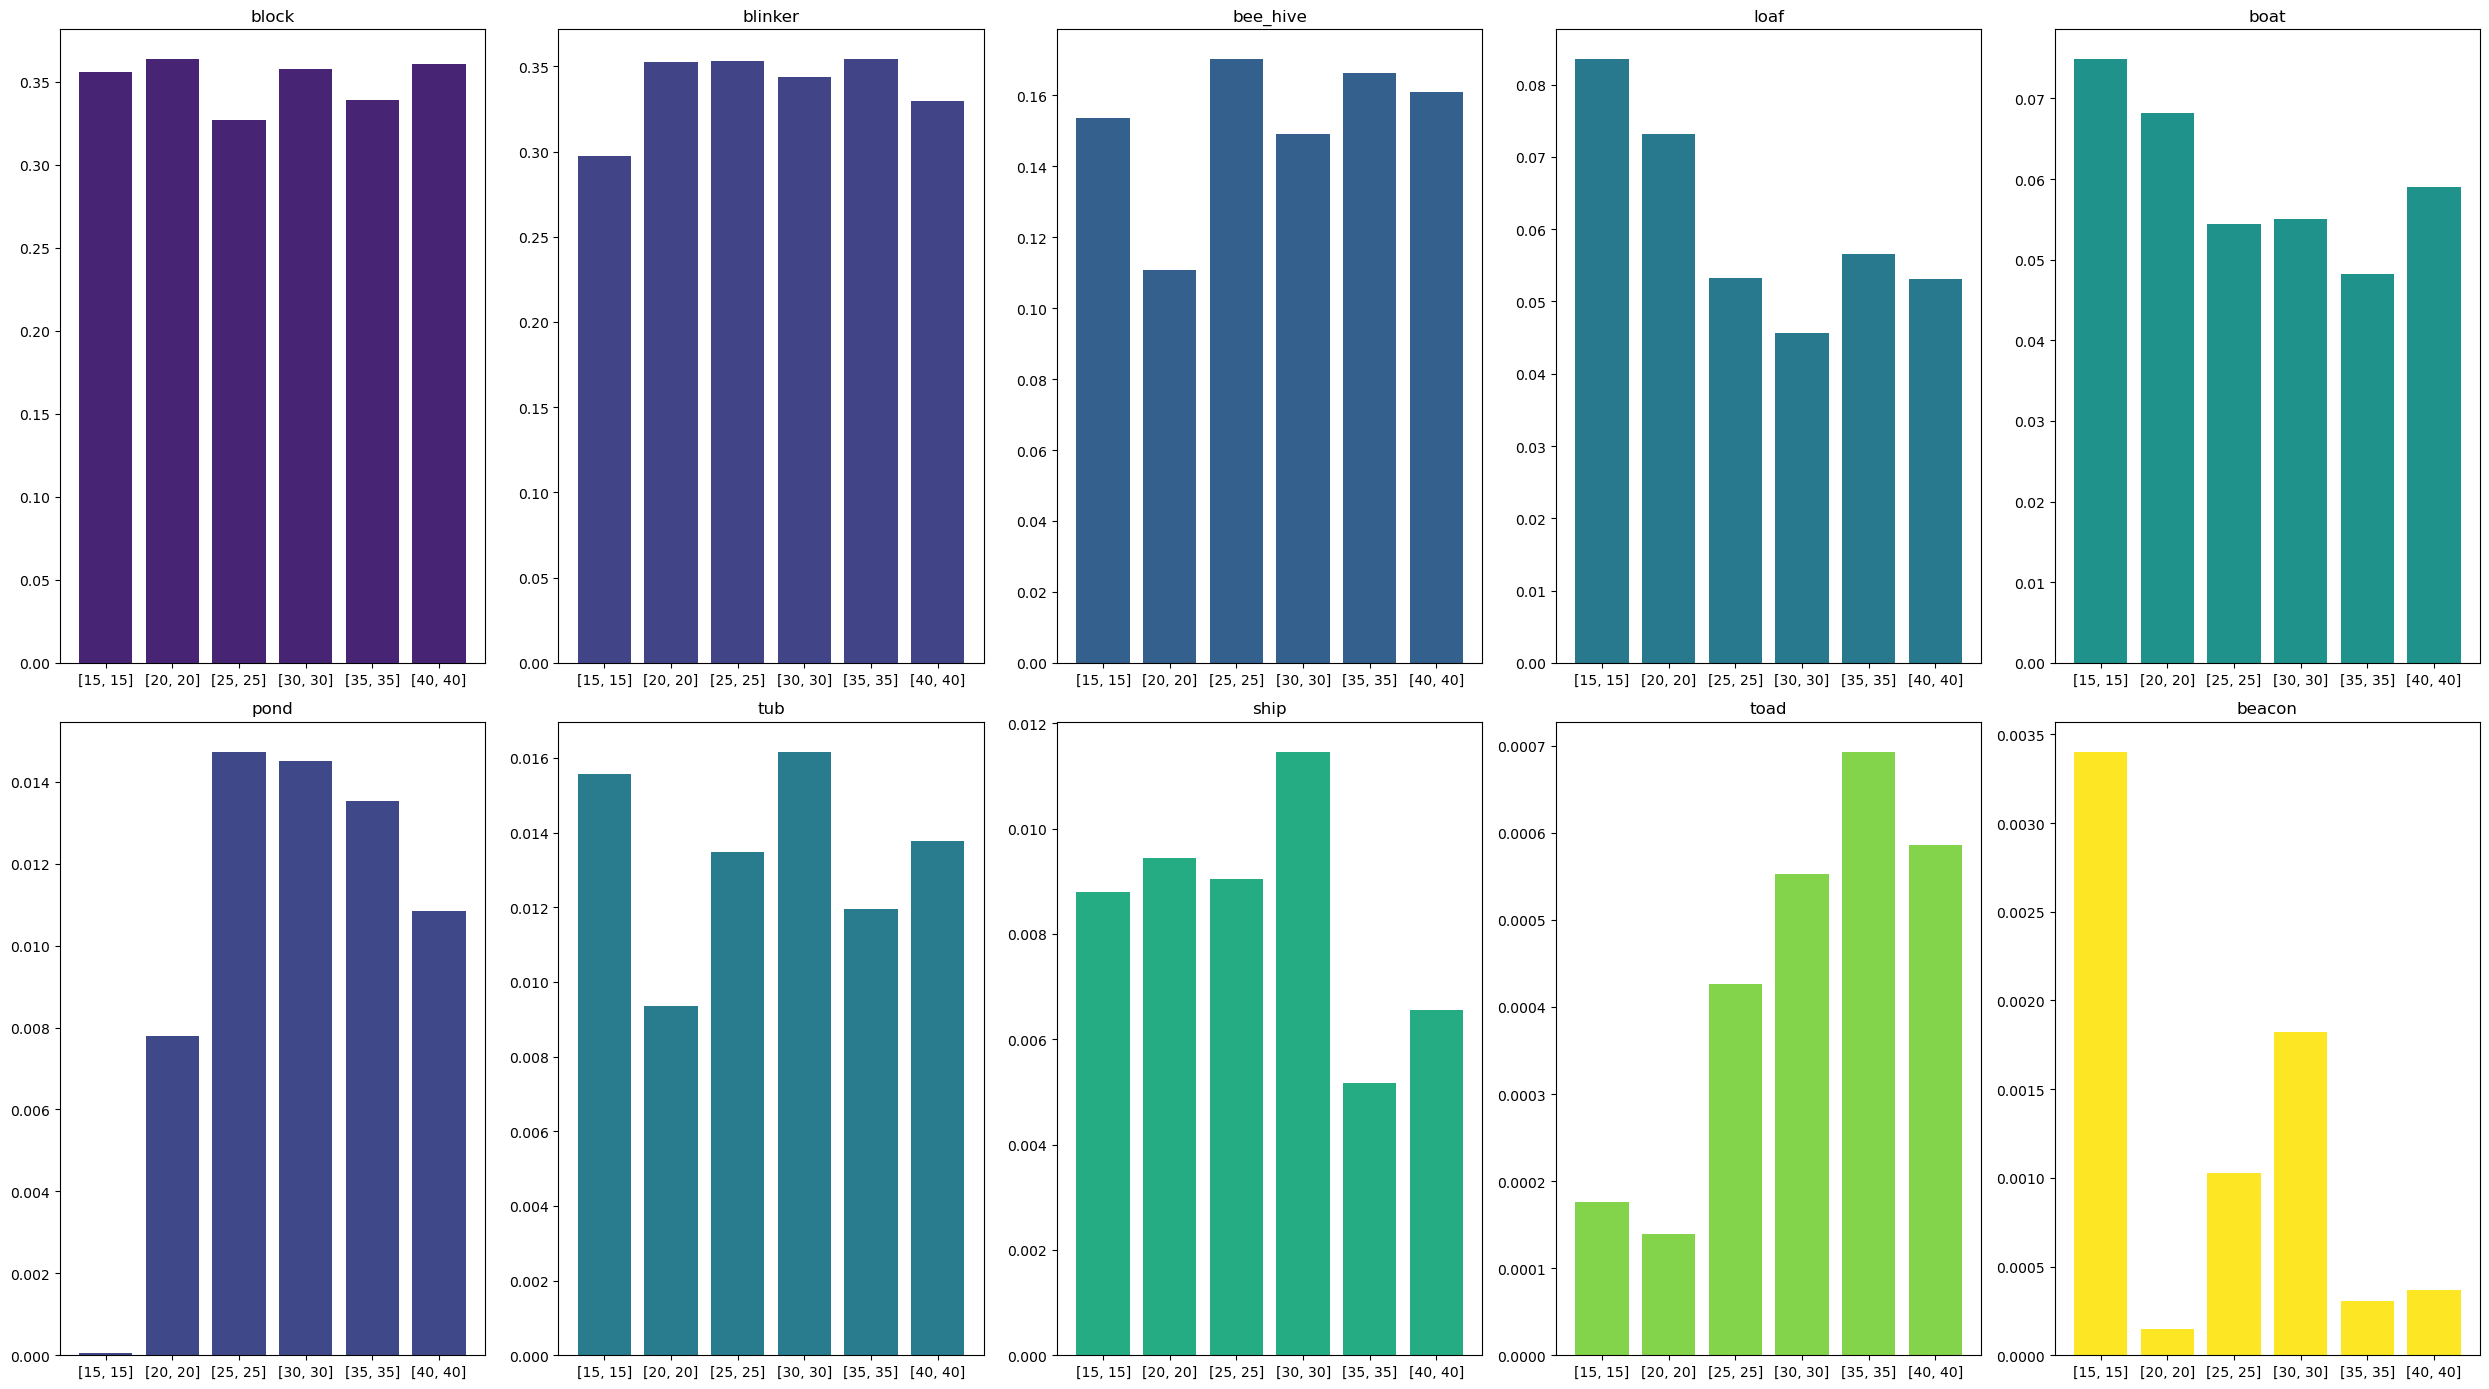

In [39]:
fig, ax = plt.subplots(ncols=5, nrows=2, figsize=(25, 14))
my_colors = [(x/10.0, x/20.0, 0.4) for x in range(df_final2.shape[1]-1)]
my_cmap = cm.get_cmap('viridis')
rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))
labels = [item.get_text() for item in ax[0, 0].get_xticklabels()]
labels = [str(dim) for dim in all_dim]
for j in range(2):
    for i in range(5):
        offset = (i+1)*(j+1)*25
        ax[j, i].bar(df_print.index, df_print[subpat[i+5*j]], label='Dimensions', color=my_cmap(i+5*j+offset)) #(0.2, 0.4, 0.6, 0.6)
        ax[j, i].set_title(subpat[i+5*j])
        ax[j, i].xaxis.set_ticks(list(range(6)))
        ax[j, i].set_xticklabels(labels)
plt.tight_layout()
plt.savefig('plots/'+"all_all"+'.png', bbox_inches='tight', dpi=300)
plt.show()

In [12]:
K = np.array(K)
K_err = np.array(K_err)
r = np.array(r)
r_err = np.array(r_err)
a = 1+r
x_star = r/(r+1)
x_star*K*np.array([225, 400, 325, 900, 1225, 1600])

array([   4.04226532,   32.3564258 ,  109.11815237,  468.10125577,
       1171.37068791, 2102.56129041])

In [13]:
a

array([1.00345962, 1.00538453, 1.0095134 , 1.00942493, 1.01203816,
       1.01253212])

In [21]:
import matplotlib as mpl

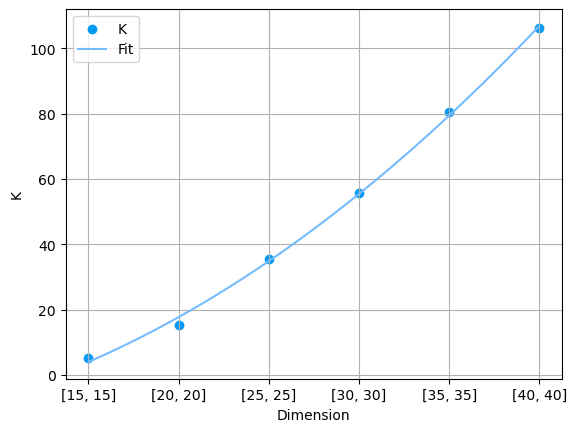

In [29]:
# How K scales with dimensions
mpl.style.use('default')
x_lab = [str(i) for i in all_dim]
def f(x, a, b, c):
    return a*x**2+b*x+c
f1 = np.vectorize(f)
popt2, pcov2 = curve_fit(f, [15, 20, 25, 30, 35, 40], K)
x = [15, 20, 25, 30, 35, 40]
plt.scatter(x_lab, K, label='K', color='xkcd:azure')
x_f = np.linspace(start=15, stop=40, num=100)
x = np.linspace(start=0, stop=5, num=100)
plt.plot(x, f1(x_f, popt2[0], popt2[1], popt2[2]), label='Fit', color='xkcd:sky blue')
# plt.xticks(ticks=x_lab)
plt.ylabel('K')
plt.xlabel('Dimension')
plt.legend()
plt.grid(True)
plt.savefig('plots/'+"K"+'.png', dpi=300)
plt.show()

In [15]:
f(40, popt2[0], popt2[1], popt2[2])

106.90285865957132

In [16]:
popt2

array([  0.06863895,   0.34337608, -16.65449726])